<a href="https://colab.research.google.com/github/Dichtael/TDS2324-TrafficAccidents/blob/EDA/CrashPrediction_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crash Prediction through Image Classification

In this model we leverage saellite images scraped from Google Maps combined with the crash coordinates of the Statistisches Bundesamt as input data for a Convolutional Neural Network (CNN). The goal is to predict the risk of a traffic accident for a specific area in a given satellite image. This likeliness will be categorized into different risk levels: 'None', 'Low', 'Moderate' and 'High'.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from fastai.vision.all import *
import zipfile

In [2]:
#!pip install fastai --upgrade -q

downloading the images out of the folder structure:

In [3]:
with zipfile.ZipFile('/content/model_img.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/traffic_images')

converting the images from .tif to .png:


In [13]:
from PIL import Image
import os

def convert_tiff_to_png(input_folder, output_folder):
    # Make sure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through each file in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Check if the file is a TIFF image
        if filename.lower().endswith(".tiff") or filename.lower().endswith(".tif"):
            # Open the TIFF image
            tiff_image = Image.open(input_path)

            # Create the output path with the same filename but a .png extension
            output_filename = os.path.splitext(filename)[0] + ".png"
            output_path = os.path.join(output_folder, output_filename)

            # Save the image as PNG
            tiff_image.save(output_path, format="PNG")

            print(f"Converted: {input_path} to {output_path}")

# Replace 'input_folder' and 'output_folder' with your actual paths
input_folder = "/content/traffic_images/model_img/4"
output_folder = "/content/traffic_images/model_png/4"

convert_tiff_to_png(input_folder, output_folder)

Converted: /content/traffic_images/model_img/4/686200_5334800.tif to /content/traffic_images/model_png/4/686200_5334800.png
Converted: /content/traffic_images/model_img/4/691720_5331880.tif to /content/traffic_images/model_png/4/691720_5331880.png
Converted: /content/traffic_images/model_img/4/700120_5334840.tif to /content/traffic_images/model_png/4/700120_5334840.png
Converted: /content/traffic_images/model_img/4/684440_5332840.tif to /content/traffic_images/model_png/4/684440_5332840.png
Converted: /content/traffic_images/model_img/4/693880_5331280.tif to /content/traffic_images/model_png/4/693880_5331280.png
Converted: /content/traffic_images/model_img/4/694040_5330800.tif to /content/traffic_images/model_png/4/694040_5330800.png
Converted: /content/traffic_images/model_img/4/690960_5336400.tif to /content/traffic_images/model_png/4/690960_5336400.png
Converted: /content/traffic_images/model_img/4/688840_5340120.tif to /content/traffic_images/model_png/4/688840_5340120.png
Converte

defining the categories and the path of the data:

In [14]:
crash_categories = '0','1','2','3','4'
path = Path('/content/traffic_images/model_png')

defining the DataBlock:

In [15]:
crash_images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 batch_tfms=aug_transforms())

creating the dataloader and inspecting a batch:

In [16]:
dls = crash_images.dataloaders(path, batch_size=4)

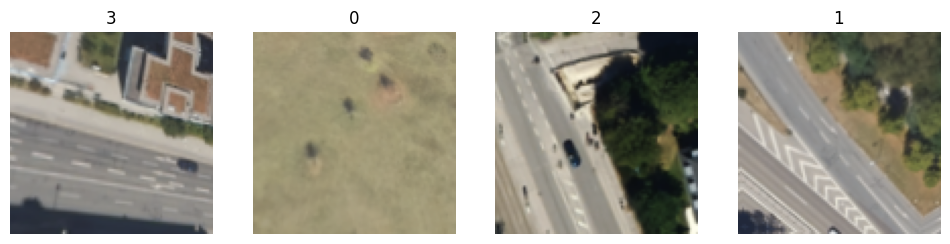

In [17]:
dls.train.show_batch(max_n=4,nrows=1)

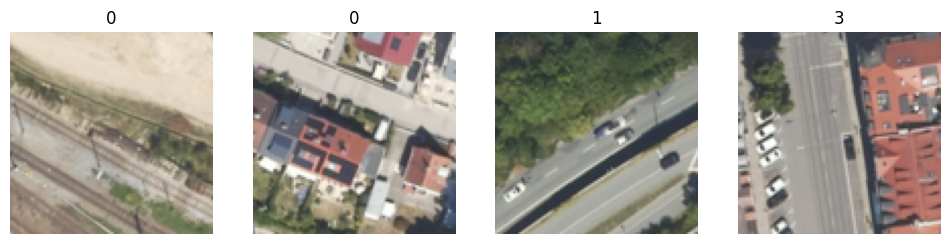

In [18]:
dls.valid.show_batch(max_n=4, nrows=1)

# Model Iteration Using 5 Classes of Crash Risks:

# First Model using ResNet18

creating the learner:

In [23]:
learn18 = vision_learner(dls, models.resnet18, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,2.303759,1.813812,0.330940,01:13
1,2.028816,1.629434,0.370104,01:41
2,1.729519,1.499067,0.362272,01:54
3,1.605296,1.436921,0.355744,01:32
4,1.618749,1.375027,0.394909,01:23
5,1.494627,1.462817,0.379896,01:42
6,1.511664,1.340537,0.412533,01:25
7,1.468907,1.346583,0.401436,01:24
8,1.396371,1.314042,0.421018,01:24
9,1.422955,1.301247,0.428198,01:47


In [ ]:
torch.save(model.state_dict(), 'learn18.pth')

finding the optimal learning rate:

In [ ]:
lr = learn18.lr_find()

training the model with the optimal leanrning rate:

In [ ]:
learn18.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

In [49]:
print("in-sample performance: {}".format(np.array(learn18.validate(ds_idx=0)[1])))

in-sample performance: 0.4647749364376068


In [50]:
print("out-of-sample performance: {}".format(np.array(learn18.validate(ds_idx=1)[1])))

out-of-sample performance: 0.458877295255661


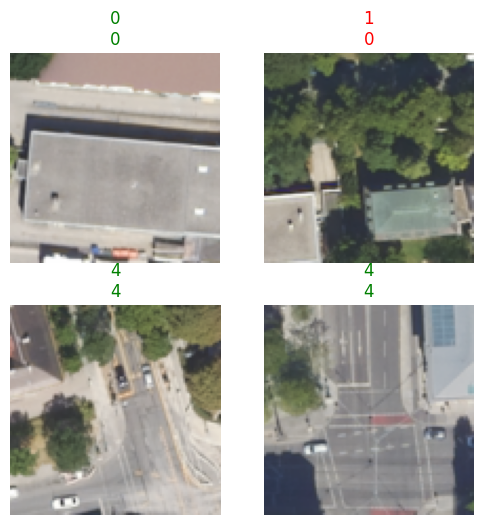

In [51]:
learn18.show_results(max_n=4)

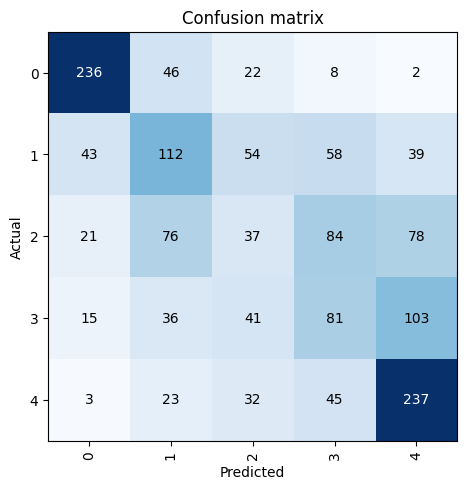

In [24]:
interp = ClassificationInterpretation.from_learner(learn18)
interp.plot_confusion_matrix()

**Model Evaluation:**


*   in-sample accuracy of 46.5 percent
*   out-of-sample accuracy of 45.9 percent
*   class 0 and 4 have a great accuracy with 74.4 and 69.7 percent being classified accurately
*   for class 1 and 3 only 38 and 30.4 percent are accurately classified
*   class 2 is just distorted over the classes and is the most wrongly classified as class 1



# Second Model using ResNet34

In [25]:
learn34 = vision_learner(dls, resnet34, metrics=accuracy)

finding the optimal learning rate:

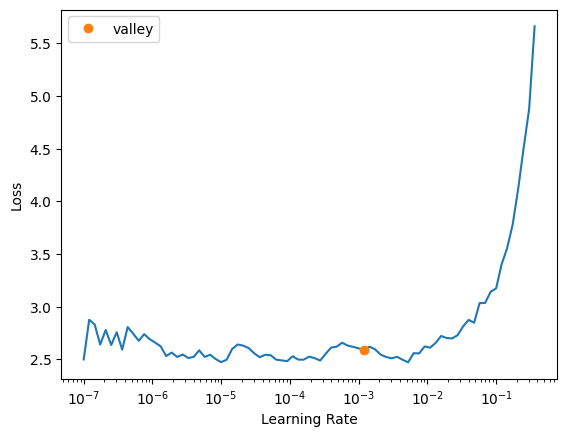

In [26]:
lr = learn34.lr_find()

training the model:

In [27]:
learn34.fit_one_cycle(20, lr_max=lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,2.192698,1.744313,0.329634,01:38
1,1.994989,1.614757,0.342689,01:51
2,1.670144,1.461286,0.366188,02:14
3,1.521960,1.461072,0.366188,02:12
4,1.583120,1.452417,0.329634,02:02
5,1.586593,1.373949,0.406658,01:51
6,1.534720,1.434141,0.396867,01:50
7,1.479054,1.324861,0.419060,02:09
8,1.456729,1.339644,0.410574,01:53
9,1.422533,1.282821,0.428198,01:51


evaluating the model on the test data:

In [28]:
print("in-sample performance: {}".format(np.array(learn34.validate(ds_idx=0)[1])))

in-sample performance: 0.4750489294528961


In [29]:
print("out-of-sample performance: {}".format(np.array(learn34.validate(ds_idx=1)[1])))

out-of-sample performance: 0.4601827561855316


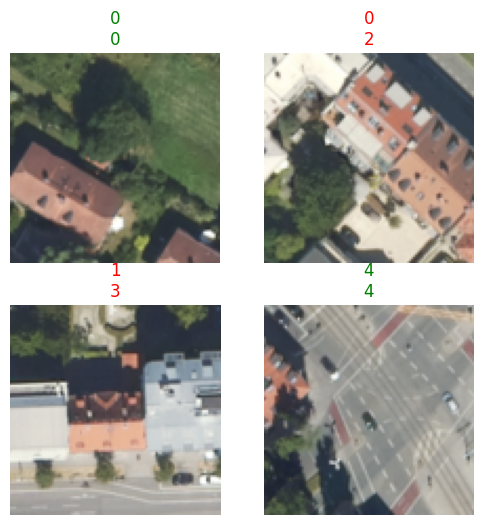

In [30]:
learn34.show_results(max_n=4)

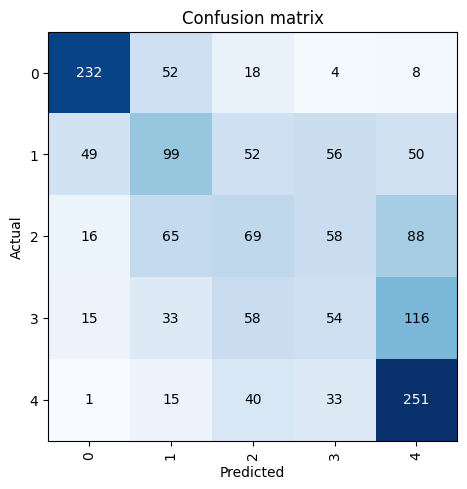

In [31]:
interp = ClassificationInterpretation.from_learner(learn34)
interp.plot_confusion_matrix()

# Third Model using ResNet50

In [32]:
learn50 = vision_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 76.2MB/s]


finding the optimal learning rate:

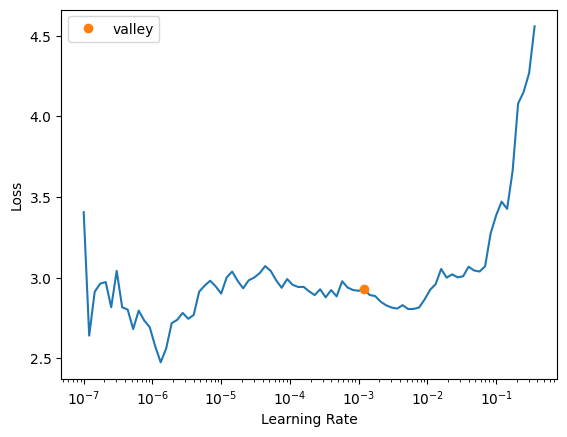

In [33]:
lr = learn50.lr_find()

training the model:

In [34]:
learn50.fit_one_cycle(20, lr_max=lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,2.256854,2.151200,0.258486,02:35
1,1.914753,1.702364,0.295039,02:50
2,1.702785,1.528183,0.327024,02:22
3,1.594412,1.480562,0.330287,02:28
4,1.613166,1.533424,0.367493,02:24
5,1.624615,1.488041,0.332245,02:19
6,1.543479,1.509002,0.368799,02:20


epoch,train_loss,valid_loss,accuracy,time
0,2.256854,2.151200,0.258486,02:35
1,1.914753,1.702364,0.295039,02:50
2,1.702785,1.528183,0.327024,02:22
3,1.594412,1.480562,0.330287,02:28
4,1.613166,1.533424,0.367493,02:24
5,1.624615,1.488041,0.332245,02:19
6,1.543479,1.509002,0.368799,02:20
7,1.518616,1.476211,0.354439,02:17
8,1.419058,1.425536,0.383812,02:18
9,1.446483,1.530210,0.372063,02:24


evaluating the model on the test data:

In [45]:
print("in-sample performance: {}".format(np.array(learn50.validate(ds_idx=1)[1])))

in-sample performance: 0.4601827561855316


In [46]:
print("out-of-sample performance: {}".format(np.array(learn50.validate(ds_idx=1)[1])))

out-of-sample performance: 0.4601827561855316


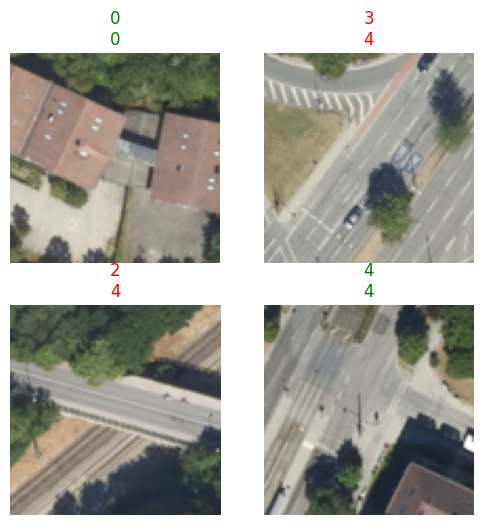

In [47]:
learn50.show_results(max_n=4)

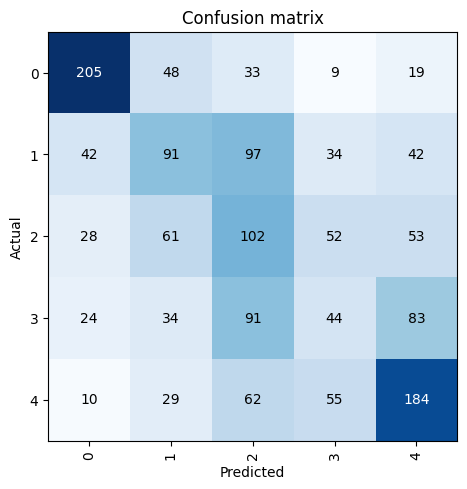

In [35]:
interp = ClassificationInterpretation.from_learner(learn50)
interp.plot_confusion_matrix()

# Model Iteration Using 3 Classes of Crash Risks:

In [52]:
with zipfile.ZipFile('/content/model_img_2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/traffic_images')

In [53]:
crash_categories = '0','1','2'
path = Path('/content/traffic_images/model_img_2')

creating the data blocks:

In [54]:
crash_images = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 batch_tfms=aug_transforms())

creating the data loaders and inspecting a batch:

In [55]:
dls = crash_images.dataloaders(path, batch_size=4)

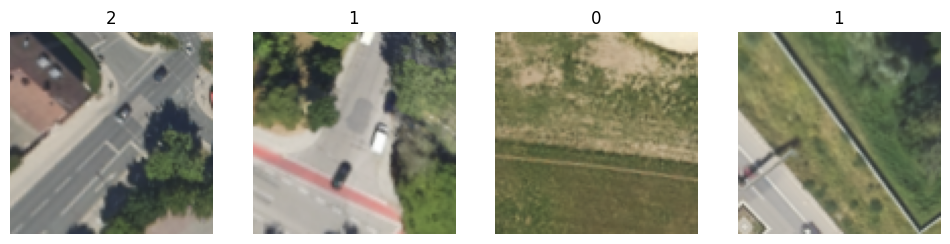

In [56]:
dls.train.show_batch(max_n=4,nrows=1)

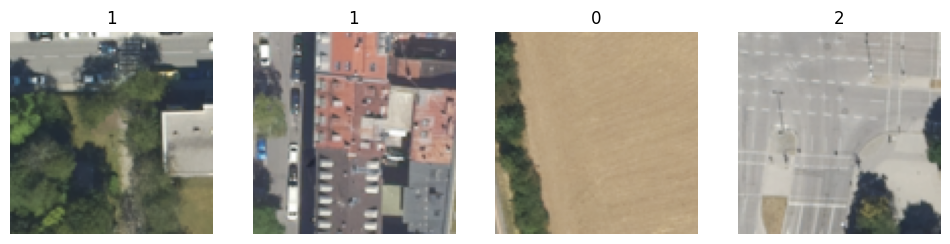

In [57]:
dls.valid.show_batch(max_n=4,nrows=1)

# First Model Using ResNet18

In [58]:
learn18_2 = vision_learner(dls, resnet18, metrics=accuracy)

identifying the optimal learning rate:

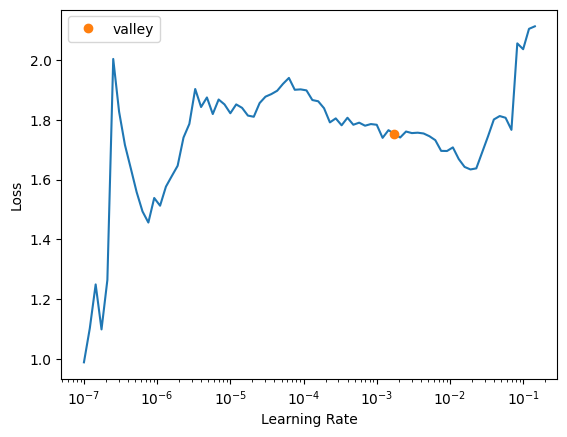

In [59]:
lr = learn18_2.lr_find()

training the model with the optimal learning rate:

In [60]:
learn18_2.fit_one_cycle(20, lr_max=lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,1.501809,1.095130,0.536667,00:56
1,1.289107,1.059452,0.546667,00:39
2,1.079058,0.947058,0.580000,00:46
3,1.031581,0.919378,0.566667,00:58
4,1.056761,0.871186,0.615556,00:47
5,1.001786,0.898166,0.597778,00:41
6,1.021244,0.806933,0.640000,01:03
7,0.917531,0.703553,0.668889,00:53
8,0.926923,0.739371,0.660000,00:38
9,0.931621,0.701187,0.664444,00:54


KeyboardInterrupt: 

evaluating the model on the test data:

In [ ]:
print("in-sample performance: {}".format(np.array(learn18.validate(ds_idx=1)[1])))

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn18.validate(ds_idx=1)[1])))

In [ ]:
learn18.show_results(max_n=4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn18)

In [ ]:
interp.plot_confusion_matrix()

# First Model Using ResNet34

In [ ]:
learn34 = vision_learner(dls, resnet34, metrics=accuracy)

identifying the optimal learning rate:

In [ ]:
lr = learn34.lr_find()

training the model with the optimal learning rate:

In [ ]:
learn34.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:


In [ ]:
print("in-sample performance: {}".format(np.array(learn34.validate(ds_idx=1)[1])))

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn34.validate(ds_idx=1)[1])))

In [ ]:
learn34.show_results(max_n=4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn50)

In [ ]:
interp.plot_confusion_matrix()

# First Model Using ResNet50

In [ ]:
learn50 = vision_learner(dls, resnet50, metrics=accuracy)

identifying the optimal learning rate:

In [ ]:
lr = learn50.lr_find()

training the model with the optimal learning rate:

In [ ]:
learn50.fit_one_cycle(20, lr_max=lr.valley)

evaluating the model on the test data:

In [ ]:
print("in-sample performance: {}".format(np.array(learn50.validate(ds_idx=1)[1])))

In [ ]:
print("out-of-sample performance: {}".format(np.array(learn50.validate(ds_idx=1)[1])))

In [ ]:
learn50.show_results(max_n=4)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn50)
interp.plot_confusion_matrix()

# Online Application of the Predictor

In [ ]:
!pip install -U kaleido

In [ ]:
!pip install openai


In [ ]:
!pip install tiktoken

In [ ]:
!pip install cohere

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr

defining the image classification function:

In [ ]:
#loading the labels
labels = learn50.dls.vocab

def classify_image(satellite_image):
  inp = inp.reshape((-1, 100, 100, 3))
  prediction = learn50.predict(inp).flatten()
  confidences = {labels[i]: float(prediction[i]) for i in range(1000)}
  return confidences

deploying the gradio interface:

In [ ]:
crash_predictor = gr.Interface(fn=classify_image,
             inputs=gr.Image(shape=(100, 100)),
             outputs=gr.Label(num_top_classes=len(labels)))
crash_predictor.launch(share=True)